In [55]:
import cv2
import json
import tensorflow
import keras
import pdf2image
import numpy as np
from tqdm.notebook import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import os
import time
import imutils

# Instantiate staff_line_space value for exponential smoothing
# and alpha value
staff_line_space = 10
EXP_ALPHA = 0.3
start_x = 0

def load_image(fileName):
    img = Image.open(fileName).convert("L")
    img.load()
    data = np.asarray(img)
    return data

def save_image(array, path):
    img = Image.fromarray(array, "L")
    img.save(path)

def RLE(array:np.ndarray):
    run_length_encoding = np.zeros(shape=[1, array.shape[0]], dtype='float')
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if array[i][j] < 200:
                run_length_encoding[0][i] += .01
    return run_length_encoding

def image_to_staffs(page, filename:str):
    global staff_line_space
    global EXP_ALPHA
    staffs = []
    array =  np.array(page.convert("L"))

    run_length_encoding = RLE(array)

    # Get max value of MLE list
    max_encoding = np.max(run_length_encoding)

    # Get potential indices for the staves
    # It is recognized by compare the RLE of each pixel to the the max_encoding value
    # (multiplied with a coeff to ensure that we get all the potential indices of the staves)
    img_indices = []
    for i in range(run_length_encoding.shape[1]):
        if run_length_encoding[0][i] >= max_encoding * .8:
            img_indices.append(i)

    # Then use it to get all the start and end indices of each staff
    staffs_index = []
    start_index = 0
    for i in range(1, len(img_indices) - 1):
        # ####### naive method
        # if i == (len(img_indices) - 2):
        #     staffs_index.append((img_indices[start_index], img_indices[len(img_indices) - 1]))
        #     break
        # range_between = abs(img_indices[i] - img_indices[i + 1])
        # if range_between >= biggest_range * .15:
        #     staffs_index.append((img_indices[start_index], img_indices[i]))
        #     start_index = i + 1
        
        ####### predict staff line space size using exponential smoothing
        if i == (len(img_indices) - 2):
            staffs_index.append((img_indices[start_index], img_indices[len(img_indices) - 1]))
            break
        
        range_between = abs(img_indices[i] - img_indices[i + 1])
        
        # space size between staffs is usually bigger than
        # 3 * space sizes between staff lines
        if range_between > staff_line_space * 4:
            staffs_index.append((img_indices[start_index], img_indices[i]))
            start_index = i + 1
        # if space between staff is not detected => only space between 2 staff lines
        # and internal space of ONE line is left.
        # space size between staff lines is usually bigger than 5 pixels
        elif range_between > 5:
            staff_line_space = int(EXP_ALPHA * staff_line_space + (1 - EXP_ALPHA) * range_between)

    count = 0
    # Generate images of single staff with the previous list of indices
    for pair in staffs_index:
        start = pair[0]
        end = pair[1]
        # Slice vertically
        staff_size = end - start
        staff = np.array(array[start - int(staff_line_space * 2):end + int(staff_line_space * 2), 0:array.shape[1]])

        # Slice horizontally (to get rid of adundant white spaces)
        for i in range(staff.shape[1] - 1):
            columns = array[start:end, i:i + 1]
            average_pixel_of_column = np.average(columns)
            if average_pixel_of_column < 250:
                start_x = i
                break

        for i in range(staff.shape[1] - 1, 0, -1):
            columns = array[start:end, i - 1:i]
            average_pixel_of_column = np.average(columns)
            if average_pixel_of_column < 250: 
                end_x = i
                break
        staff = staff[0:staff.shape[1], start_x - 100:end_x + 100] # Pad 100 pixel for later boxing
        # Append staff to list of staves
        
        staff = cv2.copyMakeBorder(staff, staff_line_space, staff_line_space, 0, 0, 0, value=[255,255,255])
        # Save the staff to image
        img = Image.fromarray(staff)

        # Logic to generate the image filename
        staff_image_name = f'{filename}_pg{count}.png'
        img.save(f'D:\\model_data\\{staff_image_name}')
        count += 1

        staffs.append(staff_image_name)

    return staffs

def pdf_to_images(pdf_path):
    # Export pdf pages as images
    pages = pdf2image.convert_from_path(f'test_images\\{pdf_path}.pdf', poppler_path="poppler-24.07.0\\Library\\bin", size=(2500, 3234), first_page=1, last_page=2)

    return pages

def find_best_coeff(template, img2, res_max_global, increasing=True, decreasing=True, time=False):
    max_matches = 0
    best_coeff = 1
    template_copy = template

    ###################Decreasing:
    if decreasing:
        for i in range(6):
            template = template_copy
            img = img2.copy()
            # Scaling coeff in range [0.2, 1] with step = 0.1
            coeff = 1 - i/10.0
            template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
            w, h = template.shape[::-1]

            try:
                res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            except:
                continue
            res_max = res.max()

            threshold = res_max_global
            loc = np.where(res >= threshold)
            indices = set()
            for pt in zip(*loc[::-1]):
                x = int(pt[0] + w/2)
                upper_bound = x + int(w * 1.5)
                lower_bound = x - int(w * 1.5)
                found = False
                for i in range(lower_bound, upper_bound):
                    if i in indices: 
                        found = True
                        break
                if not found:
                    indices.add(x)
            if time:
                if res_max >= res_max_global:
                    res_max_global = res_max
                    best_coeff = coeff
            elif len(indices) > max_matches and res_max >= res_max_global:
                max_matches = len(indices)
                res_max_global = res_max
                best_coeff = coeff
                

    ###################Increasing:
    if increasing:
        for i in range(6):
            template = template_copy
            img = img2.copy()
            # Scaling coeff in range [1, 1.8] with step = 0.1
            coeff = 1 + i/10.0
            template = cv2.resize(template, (0,0), fx=coeff, fy=coeff)
            w, h = template.shape[::-1]
            if(template.shape[0] > img.shape[0]): break

            try:
                res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            except:
                continue
            res_max = res.max()

            threshold = res_max_global
            loc = np.where(res >= threshold)
            indices = set()
            for pt in zip(*loc[::-1]):
                x = int(pt[0] + w/2)
                upper_bound = x + int(w * 1.5)
                lower_bound = x - int(w * 1.5)
                found = False
                for i in range(lower_bound, upper_bound):
                    if(i in indices): 
                        found = True
                        break
                if not found:
                    indices.add(x)
            if time:
                if res_max >= res_max_global:
                    res_max_global = res_max
                    best_coeff = coeff
            elif len(indices) > max_matches and res_max >= res_max_global:
                max_matches = len(indices)
                res_max_global = res_max
                best_coeff = coeff

    return(res_max_global, best_coeff)

# this function returns a tuple with 3 elements:
# 1. x coordinate where the time signature is found by template matching
# 2. width of the template that is matched (after scaling)
# 3. a string that describes the time signature (2/4, 3/4, common, ...)
def get_time_signature(filename):
    img = cv2.imread(f"D:\\model_data\\{filename}", cv2.IMREAD_GRAYSCALE)
    
    matches = {}
    for file in sorted(os.listdir('template\\time')):
        template = cv2.imread(f"template\\time\\{file}", cv2.IMREAD_GRAYSCALE)

        res_max, coeff = find_best_coeff(template, img, 0.1, time=True)
        matches[file] = (res_max, coeff)

    best_match_template = max(matches, key=matches.get)
    res_max = matches[best_match_template][0]
    best_coeff = matches[best_match_template][1]

    template = cv2.imread(f'template\\time\\{best_match_template}', cv2.IMREAD_GRAYSCALE)
    template = cv2.resize(template,(0,0),fx=best_coeff,fy=best_coeff)
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res == res_max)
    
    for pt in zip(*loc[::-1]):
        x = pt[0]
    
    return (x, w, best_match_template[:-4]) 

def get_key_signature(filename, time_x, time_w, time):
    img = cv2.imread(f"D:\\model_data\\{filename}", cv2.IMREAD_GRAYSCALE)
    
    matches = {}
    for file in sorted(os.listdir('template\\accidentals')):
        template = cv2.imread(f"template\\accidentals\\{file}", cv2.IMREAD_GRAYSCALE)

        res_max, coeff = find_best_coeff(template, img, 0.1, time=True)
        matches[file] = (res_max, coeff)
    
    best_match_template = max(matches, key=matches.get)
    res_max = matches[best_match_template][0]
    best_coeff = matches[best_match_template][1]
    if res_max < 0.65: return 0, None
    
    indices = set()
    for file in sorted(os.listdir('template\\accidentals')):
        if best_match_template[:5] in file:
            template = cv2.imread(f"template\\accidentals\\{file}", cv2.IMREAD_GRAYSCALE)
            template = cv2.resize(template,(0,0),fx=best_coeff,fy=best_coeff)
            w, h = template.shape[::-1]

            res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            loc = np.where(res >= res_max * 0.8)

            for pt in zip(*loc[::-1]):
                x = int(pt[0] + w/2)
                upper_bound = x + int(w/2)
                lower_bound = x - int(w/2)
                found = False
                for i in range(lower_bound, upper_bound):
                    if(i in indices):
                        found = True
                        break
                if not found:
                    indices.add(x)
    
    return len(indices), "sharp" if "sharp" in best_match_template[:5] else "flat"


key_signature_file = ""
notes_start_index = 0
def staff_to_boxed_notes(filename):
    global staff_line_space
    global start_x
    global key_signature_file
    global notes_start_index
    
    img = cv2.imread(f"D:\\model_data\\{filename}", cv2.IMREAD_GRAYSCALE)
    
    if 'pg0' in filename:
        time_x, time_w, time = get_time_signature(filename)
        accidentals_count, accidental = get_key_signature(filename, time_x, time_w, time)
        if accidentals_count == 0:
            key_signature_file = '0.jpg'
        else:
            key_signature_file = f'{accidentals_count}_{accidental}.jpg'
        notes_start_index = time_x + time_w
    elif 'pg1' in filename:
        print(key_signature_file)
        key_signature_template = cv2.imread(f"template\\key_signatures\\{key_signature_file}", cv2.IMREAD_GRAYSCALE)
        res_max, coeff = find_best_coeff(key_signature_template, img, 0.1, time=True)
        print(res_max, coeff)
        key_signature_template = cv2.resize(key_signature_template,(0,0),fx=coeff,fy=coeff)
        
        res = cv2.matchTemplate(img, key_signature_template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res == res_max)
        
        for pt in zip(*loc[::-1]):
            found_x = pt[0]
        notes_start_index = key_signature_template.shape[1] + found_x
    
    img = img[0:img.shape[0], notes_start_index:img.shape[1]]
    indices = set()
    
    drawn_indices = set()
    list_pt = {}
    boxes = []

    for dir in sorted(os.listdir('template\\roots_and_rests')):
        if 'rest' in dir: continue
        # The template to be matched
        template = cv2.imread(f'template\\roots_and_rests\\{dir}', cv2.IMREAD_GRAYSCALE)
        res_max, coeff = find_best_coeff(template, img, 0.7)
        template = cv2.resize(template,(0,0),fx=coeff,fy=coeff) #scale the tepmplate to the best coeff
        
        w, h = template.shape[::-1] # Get w and h of template

        try:
            res = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED) # Begin matching and get matches
        except:
            continue
        if '0' not in dir:
            threshold = res_max * 0.8
        else:
            threshold = res_max * 0.7
        loc = np.where(res >= threshold) # With threshold to offset the difference between template and notes (with staff)
        
        # Get a set of center indices of boxes for further testing
        for pt in zip(*loc[::-1]):
            x = int(pt[0] + w/2)
            upper_bound = x + int(w * 1.5)
            lower_bound = x - int(w * 1.5)
            found = False
            for i in range(lower_bound, upper_bound):
                if(i in indices):
                    found = True
                    break
            if not found:
                list_pt[x] = pt
                indices.add(x)
        for x in indices:
            # pt dimensions: (x, y)
            pt = list_pt[x]
            # draw boxes in copy of image
            if x not in drawn_indices:
                box = img[0:img.shape[0], pt[0] - int(w / 2):pt[0] + int(w * 1.75)]
                box = imutils.resize(box, width=49, height=149)
                box = cv2.resize(box, (49, 149))
                boxes.append((x + notes_start_index, box))
                # cv2.rectangle(img2, (pt[0] - int(box.shape[1]), 0), (pt[0] + int(box.shape[1]), img2.shape[0]), (0,0,255), 1)
                drawn_indices.add(x)
    
    # cv2.imwrite(f'D:\\model_data\\{filename}_boxed.jpg', img2)
    boxes.sort(key=lambda x:x[0])
    return boxes, key_signature_file

def output_staff_with_labels(staffs:list, indices:list, labels:list):
    for staff_filename in staffs:
        line_feed_index = labels.index('\n')
        staff_labels = labels[:line_feed_index]
        staff_indices = indices[:len(staff_labels)]

        image = cv2.imread(f'D:\\model_data\\{staff_filename}', cv2.IMREAD_GRAYSCALE)

        
        box_and_labels = zip(staff_indices, staff_labels)
        for item in box_and_labels:
            index = item[0]
            label = item[1]
            cv2.putText(image, label, (index - 20, 25), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,0,0), 1, cv2.LINE_AA)
        cv2.imwrite(f'D:\\model_output\\{staff_filename}', image)

        if line_feed_index != len(labels) - 1:
            labels = labels[line_feed_index + 1:]
            indices = indices[len(staff_labels):]

In [62]:
# FILE PATH AND CONSTANTS
 
H = 149
W = 49


## Current best pitch model: OMR_PITCH_MODEL_100k_CUSTOMIZED_3
## Current best duration model: OMR_DURATION_MODEL_LSTM

PITCH_MODEL = keras.models.load_model('D:\\OMR_PITCH_MODEL_110k_CUSTOMIZED_1.keras')
DURATION_MODEL = keras.models.load_model("D:\\OMR_DURATION_MODEL_LSTM.keras")
NOTES = ['D3',
         'E3',
         'F3',
         'G3',
         'A3',
         'B3',
         'C4',
         'D4',
         'E4',
         'F4',
         'G4',
         'A4',
         'B4',
         'C5',
         'D5',
         'E5',
         'F5',
         'G5',
         'A5',
         'B5',
         'C6',
         'D6',
         'E6',
         'F6'
]
DURATIONS = [
    'd_w',
    'w',
    '1/2',
    '1/4',
    '1/8',
    '1/16', 
    'thirty_second',
    'sixty_fourth',
    'hundred_twenty_eighth'
]

PDF_FILE_NAME = "auld-lang-syne-violin"
IMAGE_FILE_NAME = "Lightly_Row"

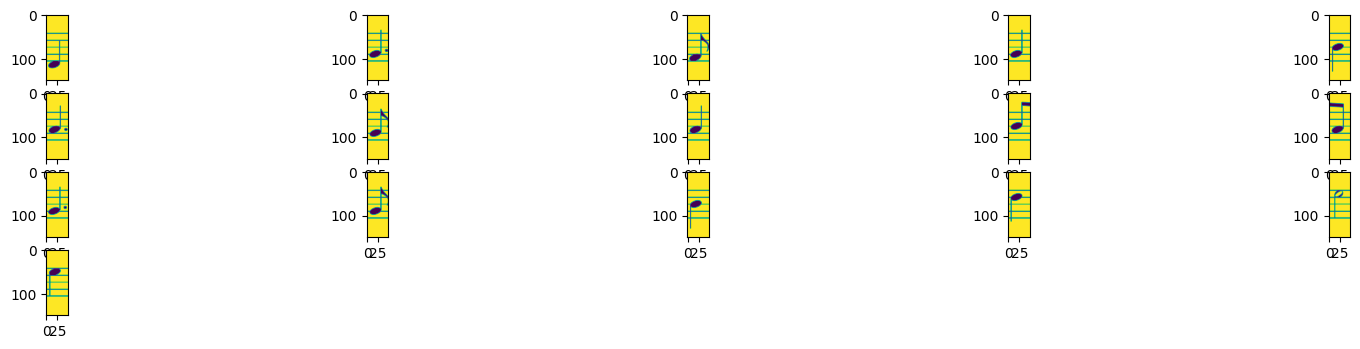

1_sharp.jpg
0.49773183 1.5


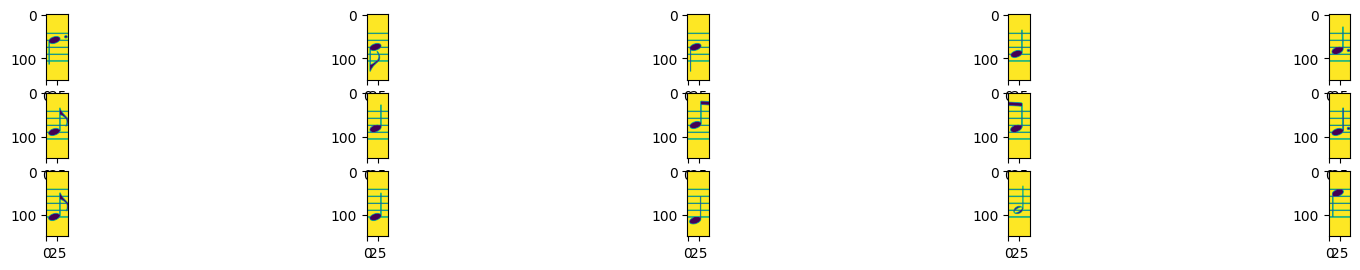

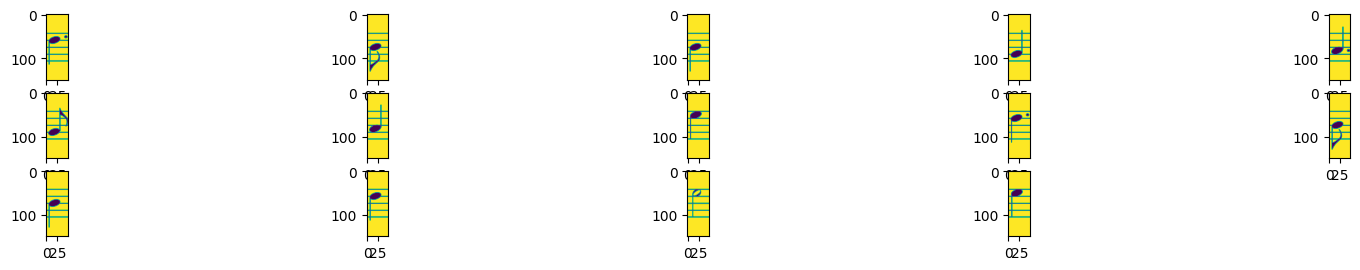

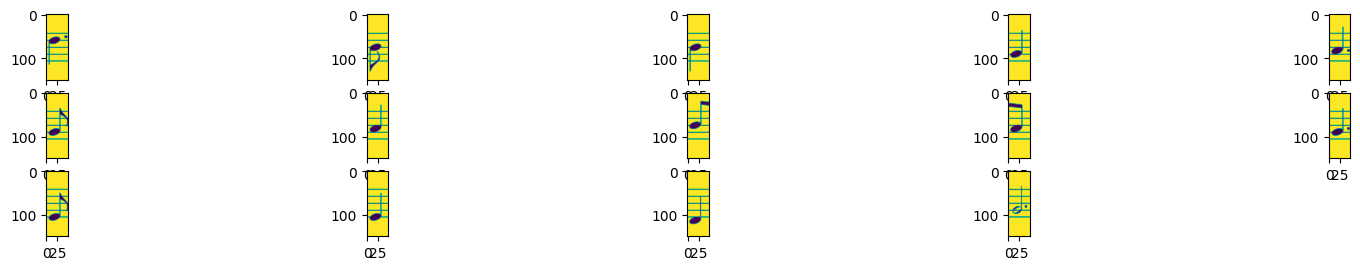

In [63]:
###############################################################################


labels = []
labels_indices = []
staffs = []

# ## Testing straight from page images
# image = Image.open(f'test_images\\{IMAGE_FILE_NAME}.jpg')
# staffs = image_to_staffs(image, IMAGE_FILE_NAME)
# ##

## Testing from pdf
images = pdf_to_images(PDF_FILE_NAME)
for image in images:
    staffs += image_to_staffs(image, PDF_FILE_NAME)
##

for staff_filename in staffs:
    arrays = []

    output, key_signature = staff_to_boxed_notes(staff_filename)
    boxed_notes = [i[1] for i in output]
    indices = [i[0] for i in output]
    
    arrays = np.array(boxed_notes)
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(20, 10))
    columns = 5
    rows = 10
    for i in range(1, len(arrays) + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(arrays[i - 1])
    plt.show()

    arrays.reshape(arrays.shape[0], H, W, 1)

    for i in range(len(arrays)):
        data = arrays[i:i+1]
        data = data.astype('float16')
        data = data/255
        pitch_result = np.argmax(PITCH_MODEL.predict(data, verbose=0))
        note = NOTES[pitch_result]
        
        duration_result = DURATION_MODEL.predict(arrays[i:i+1], verbose=0).reshape([10])
        duration = DURATIONS[np.argmax(duration_result[:9])]
        dotted = duration_result[9]
        result = note + "." + duration
        if dotted > 0:
            result += "dot"
        labels.append(result)
        labels_indices.append(indices[i])
    labels.append("\n")

output_staff_with_labels(staffs, labels_indices, labels)

In [64]:
from midiutil.MidiFile import MIDIFile as midi

NOTES = {'D3':54,
         'E3':56,
         'F3':57,
         'G3':59,
         'A3':61,
         'B3':63,
         'C4':64,
         'D4':66,
         'E4':68,
         'F4':69,
         'G4':71,
         'A4':73,
         'B4':75,
         'C5':76,
         'D5':78,
         'E5':80,
         'F5':81,
         'G5':83,
         'A5':85,
         'B5':87,
         'C6':88,
         'D6':90,
         'E6':92,
         'F6':93
}

DURATIONS = {
    'd_w':8,
    'w':4,
    '1/2':2,
    '1/4':1,
    '1/8':0.5,
    '1/16':0.25
}

SHARP = {
    '1':['F'],
    '2':['F', 'C'],
    '3':['F', 'C', 'G']
}

FLAT = {
    '1':['B'],
    '2':['B', 'E'],
    '3':['B', 'E', 'A']
}

accidentals = []

if 'sharp' in key_signature:
    accidentals = SHARP[key_signature[:1]]
elif 'flat' in key_signature:
    accidentals = FLAT[key_signature[:1]]

mf = midi(1)
track = 0 # the only track (monophonic)

time = 0 # start at the beginning

mf.addTrackName(track, time, "Output Track")
mf.addTempo(track, time, 120)

channel = 0
volume = 90 # 0 - 127

time = 0
for label in labels:
    dot = False
    if '\n' in label:
        continue
    if 'dot' in label:
        dot = True
        label = label[:-3]

    pitch_label = label[:2]
    duration_label = label[3:]

    pitch = NOTES[pitch_label]
    for accidental in accidentals:
        if accidental in pitch_label:
            pitch += 1
    duration = DURATIONS[duration_label]
    if dot: duration += (duration / 2)

    mf.addNote(track, channel, pitch, time, duration, volume)
    time += duration

with open("output.mid", "wb") as f:
    mf.writeFile(f)
    